<img src="media/coco-banner.jpg">

# Xarray

[_Xarray_](https://docs.xarray.dev/) is a Python package that makes working with labelled multi-dimensional arrays (like stacks of images) in Python simple, efficient, and fun. It has extensions for specific domains, for example the [Rioxarray](https://corteva.github.io/rioxarray) adds functionality for geospatial raster data. The name "RIO" comes from "RasterIO"(Input/Output), because the extension makes use of yet another great open source package [RasterIO](https://rasterio.readthedocs.io).   

We will learn about:
* How to open a satellite image ([Landsat Collection 2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2))
* How to extract quantitative data from geospatial coordinates
* How to make different plots
* How to save an image for GIS software like [QGIS](https://www.qgis.org/)
* How to scale analysis with *lots* of images using [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/)

---

Xarray hace que trabajar con datos n-dimensionales (conjuntos de imagenes) sea sencillo, eficaz, y divertido! Tiene extenciones para varios dominios cientificos, por ejemplo Rioxarray aggrega funciones para trabajar con datos cuadriculares geospaciales (imagenes de satellite) comun en geociencias. El nombre 'RIO' viene de "RasterIO" (IO = Input/Output), porque la extencion utiliza otro paquete libre en Python: RasterIO.

Vamos a aprender:
* Abrir imagenes satelitales (Landsat Collection 2)
* Extraer datos cuantativos segun coordenates geospaciales
* Crear graficas analyticas
* Guardar un imagen para otro software como QGIS
* Empezar a analysis conjuntos de imagenes con Microsoft Planetary Computer

![Xarray Diagram](https://docs.xarray.dev/en/stable/_images/dataset-diagram.png)

## Import Xarray | Importar Xarrray

In [1]:
import xarray as xr
xr.__version__

'2023.2.0'

We also import other packages that we're going use in this notebook | También importamos otros paquete que usaremos en este notebook.

In [2]:
import matplotlib.pyplot as plt
import requests
import os

import planetary_computer
import geopandas as gpd
import pystac_client
import odc.stac

Do not worry about understanding the following cell, you can come back to it later. It creates a local copy of an image that we will use for this tutorial

---

No es necesario revisar la celula siguiente, puedes volver a estudiarlo despues. El Codigo crea un archivo de la imagen que usaremos.

In [3]:
# Example Raster from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#Example-Notebook
tif_url = 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/046/027/LC08_L2SP_046027_20210725_20210803_02_T1/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5.TIF'
output = './data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5_OV2.tif'

def save_local_copy(tif, output):
    """ Save low resolution geotiff from planetary computer for tutorial """
    
    URL = f'https://planetarycomputer.microsoft.com/api/sas/v1/sign?href={tif}'
    response = requests.get(URL).json()
    signed_url = response['href'] # also "msft:expiry" (45min if anonymous request)
    
    if not os.path.exists(output):
        da = xr.open_dataarray(signed_url, 
                               engine='rasterio',
                               open_kwargs=dict(overview_level=2)
                              )
        da.rio.to_raster(output)
        

save_local_copy(tif_url, output)

☝️ Many remote sensing datasets require authentication to access (NASA uses ["Earth Data Login"](https://urs.earthdata.nasa.gov). Microsoft's Planetary Computer uses an [API to sign URLs](https://planetarycomputer.microsoft.com/docs/concepts/sas/) given time-limited access. This is why we create a `signed_url` above. Note we stored a local copy for convenience (LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5_OV2.tif), but Xarray can also read files directly from URLs! 

---

Muchos archivos de imagenes satelitales requiren que obtengas permiso para bajar datoes (NASA utiliza "Earth Data Login", Microsoft Planetary Computer utiliza un API para creare vinculos valido por un tiempo limitado. Por eso arriba creamos un `singed_url`. Ojo: Guardamos una copia del archivo (LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5_OV2.tif), pero Xarray tambien puede leer directamente del URL:

## How to read data? | ¿Cómo abrir datos?

### DataArray

A _DataArray_ is a N-dimensional data structure. Commonly with geospatial data we have a cube with 3 dimensions: x,y,time. But you could add even more dimensions like 'depth', 'band', 'polarization', 'experiment number',  etc. Xarray provides nice HTML-representations of it's data objects when you're using a Jupyter Notebook:
 
---

_DataArray_ es una representacion de datos regulares con N-dimeniones. Frequentamente en geociences tenemos 3 dimensions: x,y,tiempo. A veces hay aun más dimensiones: 'profundidad', 'banda', 'polarizacion', etc. En Jupyter Notebooks Xarray te demuestra una representacion grafica conveniente de este objecto:

In [4]:
da = xr.open_dataarray('./data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5_OV2.tif', 
                       engine='rasterio',
                      )
da

<xarray.DataArray 'band_data' (band: 1, y: 987, x: 972)>
[959364 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.735e+05 4.737e+05 ... 7.062e+05 7.064e+05
  * y            (y) float64 5.373e+06 5.373e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Point

We must specifiy `engine='rasterio'` to use the RioXarray extension, which recognizes file formats like [Geotiff (.tif)](https://gdal.org/drivers/raster/index.html). Note the returned data object is a 3 dimensional DataArray ('band', 'y', 'x').

---

Usamos `engine='rasterio'` para utilizar la extension RioXarray, la cual tiene funciones para leer formatos geospaciales.

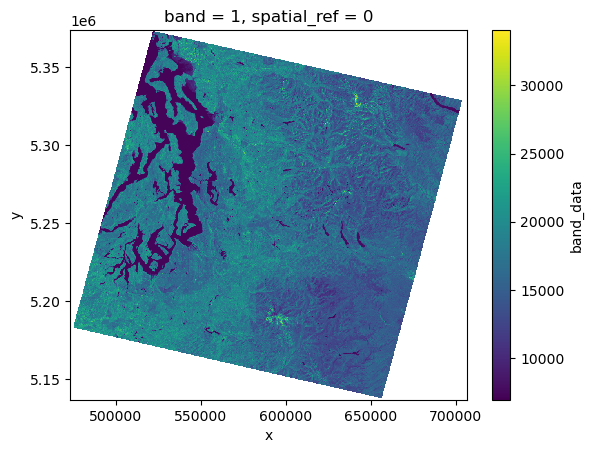

In [5]:
da.plot();

The `spatial_ref` coordinate has Coordinate Reference System (CRS) Information. This dataset is 'Universal Tranverse Mercator (UTM)'. Rioxarray has methods that can be accessed via the `.rio` attribute, for example to display the CRS (https://epsg.io/32610)

In [6]:
da.rio.crs

CRS.from_epsg(32610)

In [7]:
da.rio.resolution() #Units?

(239.84567901234567, -239.84802431610942)

In [8]:
# reproject to lon/lat
daLL = da.rio.reproject('EPSG:4326')
daLL

<xarray.DataArray 'band_data' (band: 1, y: 802, x: 1171)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -123.4 -123.4 -123.4 ... -120.2 -120.2 -120.2
  * y            (y) float64 48.51 48.51 48.51 48.51 ... 46.36 46.36 46.36 46.36
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point

Note: the dimensions have the same names ('x','y'). But now the coordinate *values* are 'longitude', 'latitude' instead of 'easting' and 'northing'. Also because we've reprojected the orginal data onto a new grid, the total size of the array has changed from (987, 972) to (802, 1171)

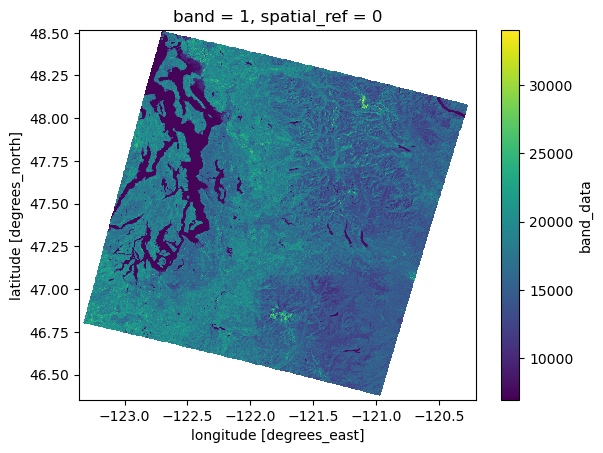

In [9]:
daLL.plot();

## Sampling | Leer valores

Xarray uses sampling based on either real-world coordinates (`.sel`) or row/col (`.isel`). This is similar to Pandas  `loc` or `.iloc` !

---

Xarray puede leer valores de los pixels con indices del coordinates geograficas (`.sel`) o fila, columna del matriz (`.isel`), similar a Pandas `.loc` y `iloc`

In [10]:
daLL.sel(y=47.0, x=-122.0, method='nearest') # Return a DataArray

<xarray.DataArray 'band_data' (band: 1)>
array([17740.], dtype=float32)
Coordinates:
    x            float64 -122.0
    y            float64 47.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point

In [11]:
daLL.sel(y=47.0, x=-122.0, method='nearest').data # Return a numpy Array

array([17740.], dtype=float32)

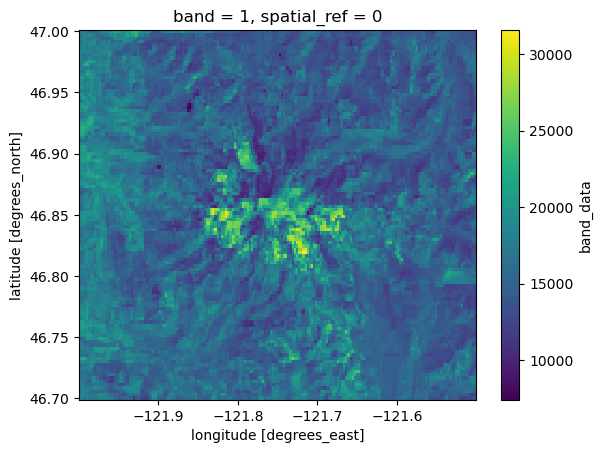

In [12]:
# Zoom in on Mt Rainier
daLL.sel(y=slice(47.0, 46.7), x=slice(-122.0, -121.5)).plot();

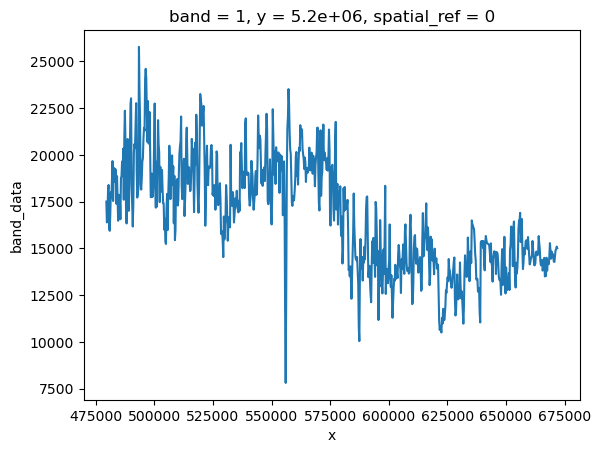

In [13]:
# Extract a profile (best in UTM for x-axis in meters)
da.sel(y=5.2e6, method='nearest').plot();

## Save a copy | Guardar archivo

Let's say we want to save a copy of our cropped image to use later or in a different program like QGIS, Rioxarray allows us to write to various formats. Geotiff is the default:

---

Si queremos guardar una copia de la imagen cortado para usar luego o abrir en software different como QGIS, Rioxarray nos permite escribe formatos diferentes. Geotiff por defecto:

In [14]:
daCrop = daLL.sel(y=slice(47.0, 46.7), x=slice(-122.0, -121.5))
daCrop.rio.to_raster('mt_rainier.tif')

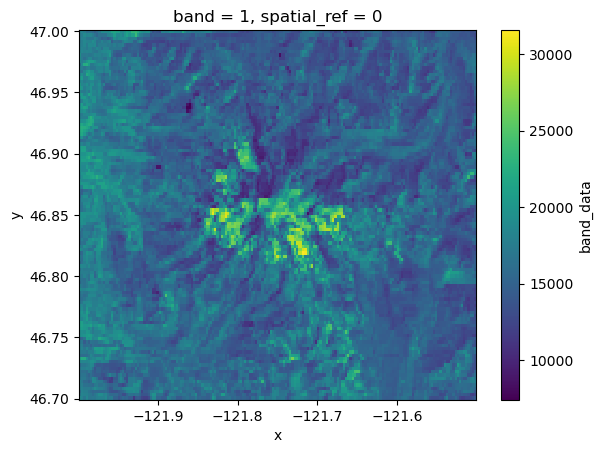

In [15]:
xr.open_dataarray('mt_rainier.tif', engine='rasterio').plot();

### DataSet (combining data) | DataSet (agregar datos)

An Xarray `DataSet` let's you store multiple variables in the same data structure. For example, different physical observables that share the same dimensions. Here we store different [Landsat Bands with their common names](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites):

---

Un `DataSet` es el objecto de Xarray para guardar variables differentes.  Por ejemple, observaciones physicas distintas las cuales comparten las mismas dimensiones. Aqui guardamos landsat bandas diferentes segun su nombre comun:

In [16]:
# Open Red Band:
tif = 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/046/027/LC08_L2SP_046027_20210725_20210803_02_T1/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B4.TIF'
output = './data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B4_OV2.TIF'

save_local_copy(tif, output)

In [17]:
# Local Copy
daB4 = xr.open_dataarray('./data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B4_OV2.tif', 
                       engine='rasterio',
                      )

# Instead of band=1, use common names for each DataArray
daB4 = daB4.assign_coords(band=['red'])
da = da.assign_coords(band=['nir'])

In [18]:
# Combine along 'band' dimension
da2 = xr.concat([da, daB4], dim='band')
da2

<xarray.DataArray 'band_data' (band: 2, y: 987, x: 972)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) <U3 'nir' 'red'
  * x            (x) float64 4.735e+05 4.737e+05 ... 7.062e+05 7.064e+05
  * y            (y) float64 5.373e+06 5.373e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point

In [19]:
# Convert to a DataSet
ds = da2.to_dataset(dim='band')
ds

<xarray.Dataset>
Dimensions:      (y: 987, x: 972)
Coordinates:
  * x            (x) float64 4.735e+05 4.737e+05 ... 7.062e+05 7.064e+05
  * y            (y) float64 5.373e+06 5.373e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 0
Data variables:
    nir          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    AREA_OR_POINT:  Point

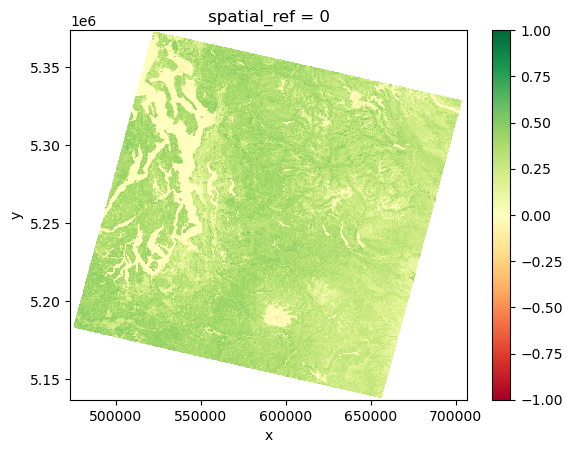

In [20]:
# This tends to be convenient for expressive computations, for example, compute NDVI:
ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)

ndvi.plot(cmap='RdYlGn', vmin=-1, vmax=1);

# Timeseries | Serie de tiempo

If you're interested in computing changes of time, you end up needing to find and read 100s or even 1000s of satellite images. While it is possible to construct DataSets like we did above piece by piece, there are other software packages that build on top of Xarray to simplify this for you. Computations that require a lot of data are best run where the large datasets are hosted. This is why Microsoft [Planetary Computer provides a JupyterHub](https://planetarycomputer.microsoft.com/docs/overview/environment/) in the same region as the data archives.

---

Si quieres calcular cambios por el tiempo, vas a necesitar cienes o miles de imagenes satelitales. Es posible construir DataSets como hicimos arriba poco a poco, pero hay otro software que nos facilita el proceso. Computaciones que requieren muchos datos son muchos mas rapidos si las hace en el mismo centro de datos, es por eso MS Planetary Computer proviene un JupyterHub.

In [21]:
bbox_of_interest = [-122.0, 46.7, -121.5, 47.0]
time_of_interest = "2020-01-01/2022-12-31" #NOTE: L8: 2013, L9: 2021

In [22]:
%%time
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=["landsat-c2-l2"],
                        bbox=bbox_of_interest,
                        datetime=time_of_interest,
                        query={"eo:cloud_cover": {"lt": 10}},
)

items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 133 Items
CPU times: user 263 ms, sys: 19.4 ms, total: 282 ms
Wall time: 2.85 s


In [23]:
# Items is a list of GeoJON Features, you can turn it into a GeoPandas table for convenient exploration:
gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
gf.head(3)

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:wrs_row,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category
0,"POLYGON ((-121.19176 48.50765, -121.81355 46.8...",30,2023-01-23T23:47:04.269172Z,10.5066/P9OGBGM6,2022-12-12T18:49:59.060473Z,landsat-8,32610,"[7791, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC80450272022346LGN00,045,2,164.304761,L2SP,17.932540,8.98,02,T1
1,"POLYGON ((-121.71004 47.08426, -122.30887 45.3...",30,2022-11-26T05:29:20.614073Z,10.5066/P9OGBGM6,2022-11-18T18:50:20.606205Z,landsat-9,32610,"[7801, 7691]",Landsat Collection 2 Level-2,"[oli, tirs]",...,028,LC90450282022322LGN00,045,2,165.039502,L2SP,23.301624,3.42,02,T1
2,"POLYGON ((-121.18859 48.50544, -121.81084 46.7...",30,2022-11-26T05:29:18.623076Z,10.5066/P9OGBGM6,2022-11-18T18:49:56.727899Z,landsat-9,32610,"[7781, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC90450272022322LGN00,045,2,165.630148,L2SP,22.004731,1.48,02,T1


In [24]:
# To integrate nicely with xarray, which uses pandas indices behind the scenes, we can assign a common index (time), as well add columns we might want to keep track of
gf['stac_id'] = [item.id for item in items]
gf['time'] = gpd.pd.to_datetime(gf.datetime) 
gf = gf.set_index('time').tz_localize(None) #drop timezone (UTC)
gf.head(3)

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category,stac_id
time,,,,,,,,,,,,,,,,,,,,,
2022-12-12 18:49:59.060473,"POLYGON ((-121.19176 48.50765, -121.81355 46.8...",30,2023-01-23T23:47:04.269172Z,10.5066/P9OGBGM6,2022-12-12T18:49:59.060473Z,landsat-8,32610,"[7791, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC80450272022346LGN00,045,2,164.304761,L2SP,17.932540,8.98,02,T1,LC08_L2SP_045027_20221212_02_T1
2022-11-18 18:50:20.606205,"POLYGON ((-121.71004 47.08426, -122.30887 45.3...",30,2022-11-26T05:29:20.614073Z,10.5066/P9OGBGM6,2022-11-18T18:50:20.606205Z,landsat-9,32610,"[7801, 7691]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC90450282022322LGN00,045,2,165.039502,L2SP,23.301624,3.42,02,T1,LC09_L2SP_045028_20221118_02_T1
2022-11-18 18:49:56.727899,"POLYGON ((-121.18859 48.50544, -121.81084 46.7...",30,2022-11-26T05:29:18.623076Z,10.5066/P9OGBGM6,2022-11-18T18:49:56.727899Z,landsat-9,32610,"[7781, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC90450272022322LGN00,045,2,165.630148,L2SP,22.004731,1.48,02,T1,LC09_L2SP_045027_20221118_02_T1


In [25]:
%%time
ds = odc.stac.stac_load(items, 
                        bands=["nir08", "red"],
                        bbox=bbox_of_interest,
                        resolution=250, # units of output CRS (UTM)
                        groupby='solar_day', # adjacent acquisition frames automatically merged
                        chunks={}, # Use Dask library to divy up large dataset
)
ds

CPU times: user 164 ms, sys: 23 ms, total: 188 ms
Wall time: 161 ms


<xarray.Dataset>
Dimensions:      (y: 137, x: 155, time: 81)
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>

In [26]:
# There is a lot of STAC metadata we can add to keep track of in this xarray object:
ds = ds.assign_coords(dict(stac_id=gf.stac_id,
                           platform=gf.platform)
                     )


/home/jovyan/.local/envs/odc/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


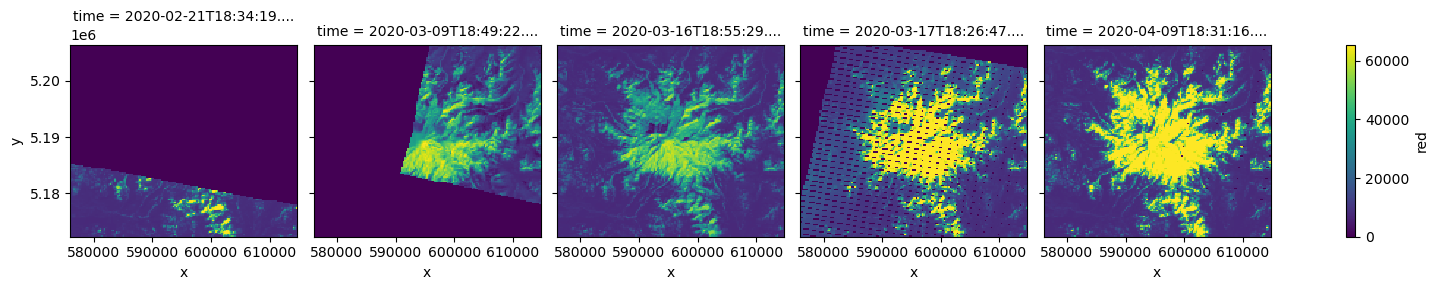

In [27]:
# It is important to understand that satellite images covering the same area of interest have variable coverage:
# Also good to review https://www.usgs.gov/landsat-missions/landsat-collection-2-known-issues 

# Use an xarray 'facet plot' https://docs.xarray.dev/en/stable/generated/xarray.plot.FacetGrid.html # 
ds.red.isel(time=slice(0,5)).plot(col='time');

In [28]:
# ? What's up with 2020-03-17?
ds.sel(time='2020-03-17')
# Image data, just like tabular data often needs significant preprocessing and cleaing
# https://www.usgs.gov/landsat-missions/landsat-7 NOTE the 2020-03-17 acquisition is Landsat 7 which has  Scan Line Corrector issues

<xarray.Dataset>
Dimensions:      (y: 137, x: 155, time: 1)
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-03-17T18:26:47.687291
    stac_id      (time) object 'LE07_L2SP_045028_20200317_02_T1'
    platform     (time) object 'landsat-7'
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>

In [29]:
# Operations are lazy
ndvi = (ds.nir08 - ds.red) / (ds.nir08 + ds.red)
ndvi

<xarray.DataArray (time: 81, y: 137, x: 155)>
dask.array<truediv, shape=(81, 137, 155), dtype=float64, chunksize=(1, 137, 155), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
    stac_id      (time) object 'LE07_L2SP_046028_20200221_02_T1' ... 'LC08_L2...
    platform     (time) object 'landsat-7' 'landsat-8' ... 'landsat-8'

In [30]:
%%time

# Here we actually read 100's of Geotiffs.
# This would be much faster on planetary computer due to minimal data transfer

pixel = ndvi.sel(x=5.9e5, y=5.18e6, method='nearest').compute() # ! Because it's a dask array we need to explicitly compute()!
pixel

CPU times: user 8.42 s, sys: 28.1 s, total: 36.5 s
Wall time: 1min 3s


<xarray.DataArray (time: 81)>
array([0.11975802,        nan, 0.12112806, 0.20720296, 0.21345085,
       0.13216137, 0.22007528, 0.2457277 ,        nan, 0.26744398,
              nan, 0.28955025, 0.26928675,        nan, 0.26826396,
              nan, 0.28347428,        nan, 0.27303043,        nan,
              nan,        nan, 0.19268702,        nan, 0.16476412,
       0.1931467 ,        nan,        nan, 0.21902486, 0.19355304,
              nan, 0.02093957, 0.03553812, 0.28452949, 0.19500757,
              nan, 0.23233944,        nan, 0.32079886, 0.29694005,
       0.30268168,        nan, 0.30718518, 0.27088036,        nan,
       0.30723938,        nan, 0.29111944, 0.29030504, 0.31922472,
              nan, 0.24797502, 0.25735188,        nan, 0.2053253 ,
       0.14873604,        nan,        nan, 0.2540366 , 0.28593442,
       0.28722329, 0.29872325, 0.28446964,        nan, 0.28779225,
       0.301944  , 0.27605997, 0.29232171, 0.3043674 , 0.28946896,
              nan, 0.2360286 , 0.23727534,        nan, 0.2026811 ,
       0.24431791, 0.21855265, 0.20544979, 0.19855929, 0.17835011,
              nan])
Coordinates:
    y            float64 5.18e+06
    x            float64 5.901e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
    stac_id      (time) object 'LE07_L2SP_046028_20200221_02_T1' ... 'LC08_L2...
    platform     (time) object 'landsat-7' 'landsat-8' ... 'landsat-8'

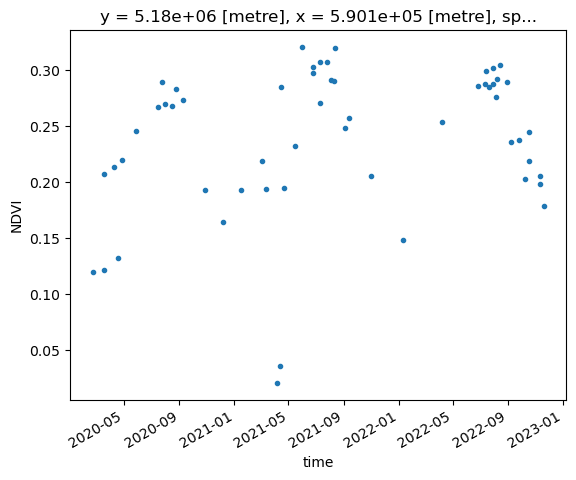

In [31]:
pixel.plot(marker='.', ls='')
plt.ylabel('NDVI');

## Homework | Tarea

* Compute an NDVI Timeseries for an area that you are interested in
* Instead of filtering the entire scene by cloud percentage, use all scenes and mask pixels by estimated cloud coverage
* Compute a different band index like [Normalized Difference Snow Index](https://www.usgs.gov/landsat-missions/normalized-difference-snow-index)
* Try the same workflow but for a different dataset, like [ESA Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)
* EXTRA: Combine Landsat8 and Sentinel2 Using the [Harmonized Landsat Sentinel (HLS) Dataset](https://planetarycomputer.microsoft.com/dataset/storage/hls)

---

* Calcular NDVI serie de tiempo para una zona que te interese
* Computar indice de bandas diferente - por ejemplo NDSI
* Intentar seguir el mismo analysis con un sensor diferente (Sentinel-2)
* EXTRA: Combinar Landsat8 y Sentinel2 usando el producto HLS

## Extra material to keep learning | Material extra para seguir aprendiendo

* The [Xarray Tutorial](https://tutorial.xarray.dev/intro.html) has lots of example notebooks from Fundamentals to Advanced
* The [Planetary Computer Documentation](https://planetarycomputer.microsoft.com/docs/overview/about) is extensive, with examples for many important remote sensing datasets.

---

* Xarray Tutorial tiene muchos ejemplos: basicos hasta avanzados.
* MS Planetary Computer Documentacion es amplio, con ejemplos para various archivos organizados por satelite